In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# julia

> An implementation of the Julia set.

In [ ]:
#| default_exp fractal.julia

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
#from abc import abstractmethod
import numpy as np
#from fractalart.core import Image
from numba import njit, prange
#from numba import njit, prange, jit
import math
#import matplotlib.pyplot as plt
from fractalart.fractal.abstract_fractal import Fractal

In [ ]:
#| export
_inv_log2 = 1.0 / math.log(2.0)

@njit
def smooth_coloring(zr, zi, iteration):
    mag_sq = zr * zr + zi * zi

    # Ensure mag_sq > 1 to avoid log(≤0)
    if mag_sq > 1e-8:
        log_zn = 0.5 * math.log(mag_sq)
        if log_zn > 1e-8:
            nu = math.log(log_zn * _inv_log2) * _inv_log2
            return iteration + 1 - nu

    return float(iteration)
    
@njit
def julia_step(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr_new = zr2 - zi2 + cr
    zi_new = 2.0 * zr * zi + ci
    return zr_new, zi_new

In [ ]:
#| export
@njit(parallel=True, fastmath=True)
def _compute_julia(x_min: float, x_max: float, y_min: float, y_max: float, cr: float, ci: float, resolution: tuple[int, int],
                     max_iter: int, fractal_fn, order: int = 1, smooth: bool = True) -> np.ndarray:
    
    width, height = resolution
    result = np.zeros((height, width), dtype=np.float64)
    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)
    inv_log2 = 1.0 / math.log(2.0)

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = zx
            zi = zy
            cr = cr
            ci = ci
            iteration = 0

            while zr * zr + zi * zi <= r2_cut and iteration < max_iter:
                zr, zi = fractal_fn(zr, zi, cr, ci)
                iteration += 1

            if smooth and iteration < max_iter:
                result[j, i] = smooth_coloring(zr, zi, iteration)
            else:
                result[j, i] = iteration

    return result

In [ ]:
class Julia(Fractal):
    def __init__(
        self,
        x_min: float = None,
        x_max: float =  None,
        y_min: float = None,
        y_max: float =  None,
        cr: float = -0.7,
        ci: float = 0.27015,
        width: int = 600,
        height: int = 600,
        max_iter: int = 200,
    ):
        if None in (x_min, x_max, y_min, y_max):
            x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self.resolution = width, height
        self.max_iter = max_iter
        self._cr = cr
        self._ci = ci
        
    def compute(self) -> np.ndarray:
        return _compute_julia(self._x_min, self._x_max, self._y_min, self._y_max, self._cr, self._ci, 
                                self.resolution, self._max_iter, julia_step)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


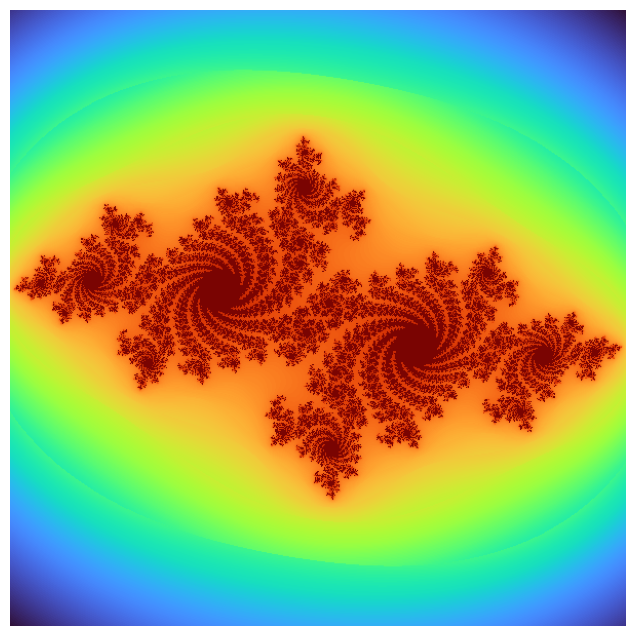

In [ ]:
j = Julia()
j.render()
j.equalize_histogram()
j.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()